# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = './traffic-signs-data/train.p'
validation_file='./traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print("Training input Data set :", X_train.shape)
print("Validation Data set :", X_valid.shape)



Training input Data set : (34799, 32, 32, 3)
Validation Data set : (4410, 32, 32, 3)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

In [2]:
#All imports in one place
# This helps with running tests on saved model.

import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
import pandas as pd
import collections
from sklearn.model_selection import train_test_split



In [5]:
def plot_dataset(counts,unique, title):
   
    plt.bar(counts,unique,.75,color="blue")
   
    plt.xlabel('Signs')
    plt.ylabel('Count of each type')
    plt.title(title)

    plt.show()



### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas
### Step 1.1

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


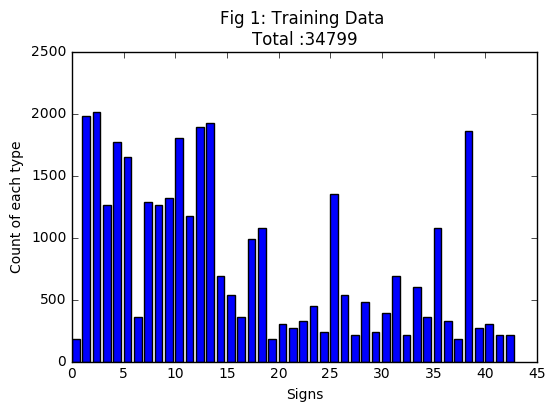

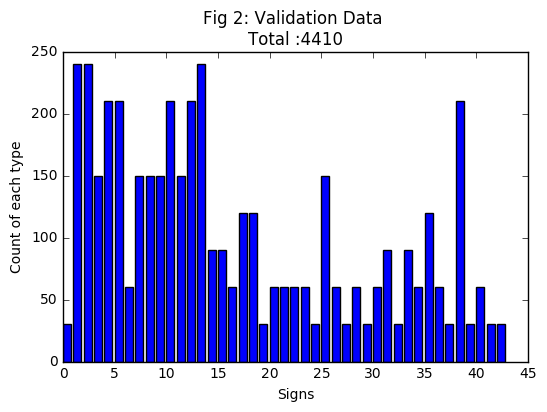

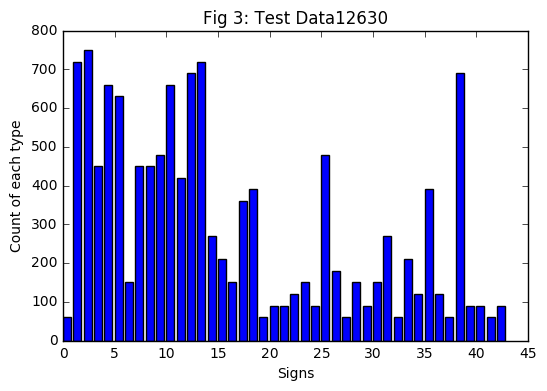

In [6]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
#import pandas as pd

df1=pd.read_csv("./signnames.csv")

# TODO: Number of training examples
n_train = X_train.shape[0]

n_valid=X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = (X_train.shape[1],X_train.shape[2])

# TODO: How many unique classes/labels there are in the dataset.
n_classes = df1.count()[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

# how many images of each type in train, valid and test dataset. Create a bar chart.

unique, counts=np.unique(y_train, return_counts=True)
plot_dataset(unique,counts,"Fig 1: Training Data \nTotal :"+str(n_train))

unique, counts=np.unique(y_valid, return_counts=True)
plot_dataset(unique,counts,"Fig 2: Validation Data \nTotal :"+str(n_valid))

unique, counts=np.unique(y_test, return_counts=True)
plot_dataset(unique,counts,"Fig 3: Test Data"+str(n_test))






### Step 1.2

In [7]:
import cv2
import numpy as np

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


#https://en.wikipedia.org/wiki/Grayscale
#def rgb2gray(rgb):
#    r, g, b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
#    grayscale = r*.212 +g*0.715 + b *.072
#    return grayscale
#
# Source: https://en.wikipedia.org/wiki/Grayscale
def rgb2gray2(rgb):
    return np.dot(rgb[...,:3], [[0.212], [0.715], [0.072]])


def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    grayscale_min = np.min(image_data)
    grayscale_max = np.max(image_data)
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )



def conv2d(x, W, b, strides=1,padding='Valid'):
    convx = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    convx = tf.nn.bias_add(convx, b)
    return convx

def dropout(x):
     dropout=0.75 # dropout percentage
     return tf.nn.dropout(x, dropout)
    
def matmul(mat1,mat2):
    return tf.matmul(mat1,mat2)

def applyRelu(x):
    return tf.nn.relu(x)

def add_dimension(x):
    size = (3,1)
    sizeone=np.ones(size)
    return np.dot(x,sizeone)


### Step 1.3

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

RGB Shape (34799, 32, 32, 3)
Gray Scale Shape (34799, 32, 32, 1)
Index: 28:Children crossing


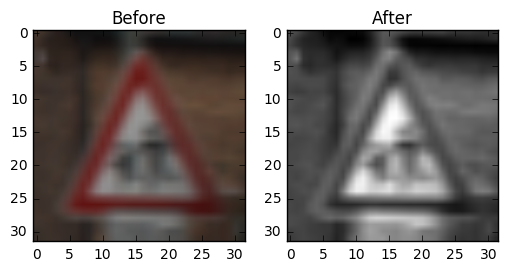

In [8]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
import numpy as np


# Visualizations will be shown in the notebook.
%matplotlib inline

# Display 5 random images and check if there labels matches from csv file for training set
# Convert RGB to GrayScale

print("RGB Shape",X_train.shape)

#Convert to Gray Scale- dot product of 32*32*3 with 3*1= 32*32*1 and then use squeeze to drop the depth.
#X_train=add_dimension(X_train)
#X_valid=add_dimension(X_valid)
#X_test=add_dimension(X_test)

#Color image

index = random.randint(0, len(X_train))
Color_image = X_train[index]

X_train=rgb2gray2(X_train)
X_valid=rgb2gray2(X_valid)
X_test=rgb2gray2(X_test)

print("Gray Scale Shape",X_train.shape)

Gray_image = X_train[index]
print("Index: "+str(y_train[index])+":"+df1["SignName"][y_train[index]])

fig = plt.figure()
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(Color_image)
a.set_title('Before')
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(Gray_image.squeeze(),cmap="gray")
a.set_title('After')



----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

Normalize Training shape (34799, 32, 32, 1)
Normalize validation shape (4410, 32, 32, 1)


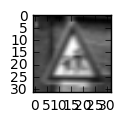

In [9]:
### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
### Feel free to use as many code cells as needed.
 
# Normalize imgage data 
# Normalize Gray Scale images

X_train=normalize_grayscale(X_train)
X_valid=normalize_grayscale(X_valid)
X_test=normalize_grayscale(X_test)

print("Normalize Training shape",X_train.shape)
print("Normalize validation shape",X_valid.shape)

#Check again how the picture look after normalization
#print(X_trainGrayNormalize) # all are between 0 and 1

imageNormalized=X_train[index]
plt.figure(figsize=(1,1))
plt.imshow(imageNormalized.squeeze(), cmap="gray")



In [10]:
import tensorflow as tf

EPOCHS = 30
BATCH_SIZE = 128
#BATCH_SIZE = 256
#BATCH_SIZE = 512



### Model Architecture

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

Step 2.1

In [11]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)
    
    # Tried dropout 
    conv1= dropout(conv1)
    
    
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    
    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits
        

In [12]:
# x->Placeholder for input image, y-> placeholder for outputput 

x = tf.placeholder(tf.float32, (None, 32, 32,1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

Step 2.2

In [13]:
# Training pipeline
rate = 0.002

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


Step 2.3

In [14]:
# Model declaration
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


Step 2.4

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the test set but low accuracy on the validation set implies overfitting.

In [15]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

# run the accuracy on test set.

# training data split, just in case to create validation dataset into training and validation features.

#shuffle training data

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)


train_features, valid_features, train_labels, valid_labels = train_test_split(
    X_train,
    y_train,
    test_size=0.20,
    random_state=832289)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    num_examples = len(X_train)
    
    print("Train size",train_features.shape)
    print("Train Validatation size",valid_features.shape)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(train_features, train_labels)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = train_features[offset:end], train_labels[offset:end]
           
            #print("batch size",batch_x[1].size)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(valid_features, valid_labels)
        print("EPOCH {} ...".format(i+1))
        print("Test Validation Accuracy = {:.3f}".format(validation_accuracy))
      
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")
    

Train size (27839, 32, 32, 1)
Train Validatation size (6960, 32, 32, 1)
Training...

EPOCH 1 ...
Test Validation Accuracy = 0.429

EPOCH 2 ...
Test Validation Accuracy = 0.688

EPOCH 3 ...
Test Validation Accuracy = 0.789

EPOCH 4 ...
Test Validation Accuracy = 0.815

EPOCH 5 ...
Test Validation Accuracy = 0.767

EPOCH 6 ...
Test Validation Accuracy = 0.857

EPOCH 7 ...
Test Validation Accuracy = 0.824

EPOCH 8 ...
Test Validation Accuracy = 0.926

EPOCH 9 ...
Test Validation Accuracy = 0.950

EPOCH 10 ...
Test Validation Accuracy = 0.922

EPOCH 11 ...
Test Validation Accuracy = 0.929

EPOCH 12 ...
Test Validation Accuracy = 0.851

EPOCH 13 ...
Test Validation Accuracy = 0.943

EPOCH 14 ...
Test Validation Accuracy = 0.867

EPOCH 15 ...
Test Validation Accuracy = 0.925

EPOCH 16 ...
Test Validation Accuracy = 0.965

EPOCH 17 ...
Test Validation Accuracy = 0.955

EPOCH 18 ...
Test Validation Accuracy = 0.814

EPOCH 19 ...
Test Validation Accuracy = 0.964

EPOCH 20 ...
Test Validation Ac

In [17]:
# Model Report Results.

#Accuracy of test set
# Model training Results:
# EPOC: 10, learning rate=0.001, batch size: 128, no dropout : Accuracy: 0.853
# EPOC: 10, learning rate=0.001, batch size: 128, no dropout : Accuracy: 0.861
# EPOC: 15, learning rate=0.001, batch size: 128, dropout(.75) : Accuracy: 0.898
# EPOC: 20, learning rate=0.002, batch size: 128, dropout(.75) : Accuracy: 0.914
# EPOC: 30, learning rate=0.001, batch size: 128, dropout(.75) : Accuracy: 0.889
# EPOC: 20, learning rate=0.002, batch size: 128, dropout(.75) : Accuracy: 0.901
# EPOC: 28, learning rate=0.002, batch size: 128, dropout(.75) : Accuracy: 0.982
#
# Looks like learning rate=0.002 and batch size 256 is giving high accuracy rate.
#      EPOC: 30, learning rate=0.002, batch size: 256, dropout(.75) : Accuracy: 0.972
# 
# best Fit: EPOC:28 , Learning rate: 0.002, batch size 256



# Test Results:

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    #saver.restore(sess, './lanet')

    validation_accuracy = evaluate(X_valid, y_valid)
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))



Validation Accuracy = 0.896
Test Accuracy = 0.886


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

./downloadedFiles/Ahead only.png


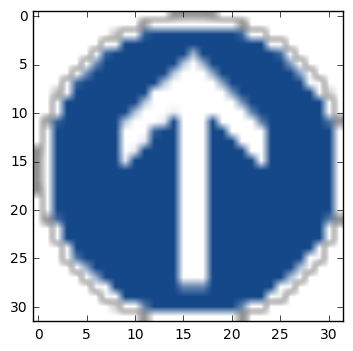

./downloadedFiles/Children crossing.png


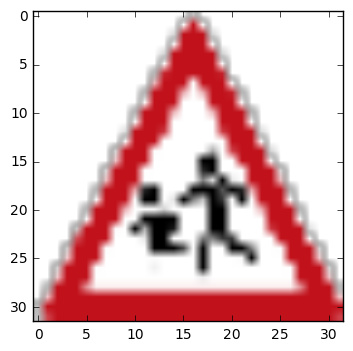

./downloadedFiles/No Entry.png


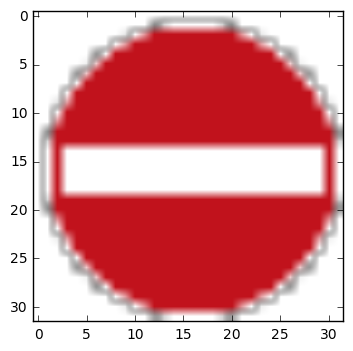

./downloadedFiles/Speed limit (60km:h).png


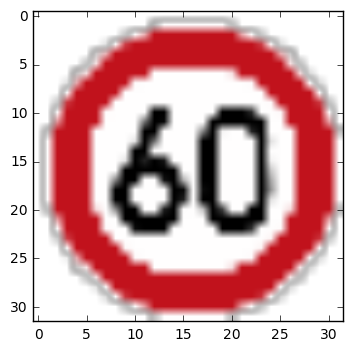

./downloadedFiles/Turn left ahead.png


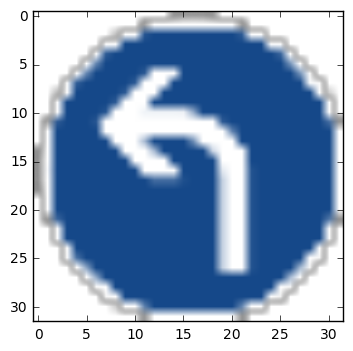

In [18]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os, glob
from PIL import Image
import matplotlib.image as matimg
import matplotlib.pyplot as plt
import numpy as np

# Image download URL : https://en.wikipedia.org/wiki/Road_signs_in_Germany

# Dowloaded 5 pictures from wiki the files are in 110*110 size, after reducing
# size to 32*32  using PIL. The new resolution is not that good. 
# Read new files and add to numpy Array at the same time.

pictureList = []
for file in glob.glob("./downloadedFiles/*.png"):
    print(file)
    image = Image.open(file)
    #image=matimg.imread(file)
    img = image.resize((32,32))
    pictureList.append(np.array(img))
    plt.imshow(img)
    plt.show()


Step 3.1

In [19]:
# Verify new image size of 32*32*1

pictureArray=np.array(pictureList)
print(pictureArray.shape)
imagegray=rgb2gray2(pictureArray.squeeze())
print(imagegray.shape)



(5, 32, 32, 4)
(5, 32, 32, 1)


Step 3.2

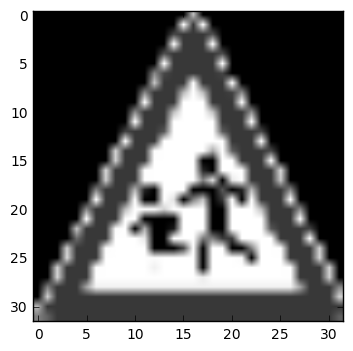

In [20]:
# Normalize pictures and display, Just to make sure if it's comming up fine.
X_images=normalize_grayscale(imagegray)
plt.imshow(X_images[1].squeeze(), cmap="gray")
plt.show()


Step 3.3

### Predict the Sign Type for Each Image

Predicted: 35, Ahead only
Correct: 35 - Ahead only
Predicted: 28, Children crossing
Correct: 28 - Children crossing
Predicted: 17, No entry
Correct: 17 - No entry
Predicted: 2, Speed limit (50km/h)
Correct: 3 - Speed limit (60km/h)
Predicted: 34, Turn left ahead
Correct: 34 - Turn left ahead
[35, 28, 17, 2, 34]


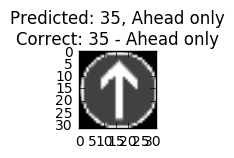

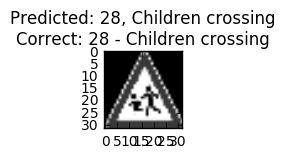

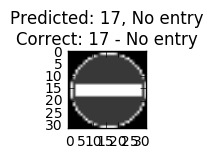

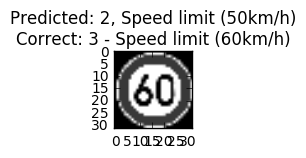

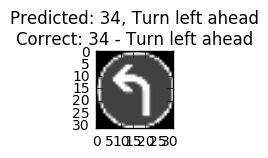

In [21]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

#df1 - Panda's dataframe created above from CSV file

correct_labels=[35,28,17,3,34] # values from signnames.CSV and files downloaded from the web: https://en.wikipedia.org/wiki/Road_signs_in_Germany

saver = tf.train.Saver()
X_labels=[]  # For integer values of output labels
with tf.Session() as sess:
    #saver.restore(sess, './lenet')
    saver.restore(sess, tf.train.latest_checkpoint('.')) 
    # this will apply logits(x) and return array of 43 items with probabilites
    image_class = sess.run(logits, feed_dict={x: X_images}) 
    
    for i in range(len(X_images)):
        image_index=np.argmax(image_class[i])
        X_labels.append(image_index)
        image = X_images[i]
        plt.figure(figsize=(1,1))
        print('Predicted: {}, {}\nCorrect: {} - {}'.format(image_index, df1["SignName"][image_index], correct_labels[i], df1["SignName"][correct_labels[i]] ))
        title = 'Predicted: {}, {}\nCorrect: {} - {}'.format(image_index, df1["SignName"][image_index], correct_labels[i], df1["SignName"][correct_labels[i]] ) 
   
        plt.title(title)
        plt.imshow(image.squeeze(), cmap="gray")
print(X_labels)


Step 3.4

### Analyze Performance

In [22]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

correct_labels=[35,28,17,3,34] # values from signnames.CSV and files downloaded from the web: https://en.wikipedia.org/wiki/Road_signs_in_Germany

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))  
    accuracy = evaluate(X_images,np.array(correct_labels) )
    print("Accuracy = {:.3f}%".format(accuracy*100))

    

Accuracy = 80.000%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

Step 3.5

In [23]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    top5 = sess.run(tf.nn.top_k(image_class, k=5, sorted=True))
    
#print(top5) 
print(" Top 5 probabilities and their classes:")
for i in range(len(top5[0])):
    print('Image', i+1, 'probability:', top5[0][i],'class:',top5[1][i])

 Top 5 probabilities and their classes:
Image 1 probability: [ 60.50321579  28.00076103  23.89371109  16.10608482   8.9125967 ] class: [35 12 14 34 33]
Image 2 probability: [ 35.04340744  10.65559769   5.89429665   1.97412419   1.16613042] class: [28  1 11 24 38]
Image 3 probability: [ 97.48392487  21.79851151  20.25235367  12.65798283  11.7533865 ] class: [17 33 14 29 26]
Image 4 probability: [ 31.72658157  17.50898361  11.61895943  10.64897728  10.45840549] class: [ 2  1  4  5 14]
Image 5 probability: [ 18.47331047   9.36174393   9.06409836   7.44846201  -5.44083834] class: [34  1 12 15 38]


> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the IPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 